Author: Jim Zhou

#1.1 Import Dataset

In [ ]:
# 1.1 Dataset
from google.colab import drive
drive.mount('/content/drive')

import math
import random
import matplotlib.pyplot as plt
from collections import defaultdict


dev = open("1b_benchmark.dev.tokens", "r")
test = open("1b_benchmark.test.tokens", "r")
train = open("1b_benchmark.train.tokens", "r")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# %cd drive/MyDrive/447_HW1/

In [ ]:
# replace words to unk in input word_count
# return a set contains all the words needed to convert to unk
def filter_unk(word_count, freq):
  word_to_unk = set()
  unk_count = 0
  for word in word_count.keys():
    if word_count[word] < freq:
      word_to_unk.add(word)
      unk_count += word_count[word]
  word_count["unk"] = unk_count
  for word in word_to_unk:
    word_count.pop(word)
  return word_to_unk

In [ ]:
# count for single word
def count_for_unitoken(lines):
  word_count_dict = {}
  for line in lines:
    cleaned_line = line.strip()
    words = cleaned_line.split()

    for word in words:
      word_count_dict[word] = word_count_dict.get(word, 0) + 1
    word_count_dict["<STOP>"] = word_count_dict.get("<STOP>", 0) + 1
  return word_count_dict

In [ ]:
# count for bigram token
def count_for_bitoken(lines, list_of_unk):
  bitoken_count_dict = {}
  for line in lines:
    pre_word = "<START>"
    cleaned_line = line.strip()
    words = cleaned_line.split()
    words.append("<STOP>")

    for word in words:
      if word in list_of_unk:
        word = "unk"
      bitoken_count_dict[(pre_word, word)] = bitoken_count_dict.get((pre_word, word), 0) + 1
      pre_word = word
  return bitoken_count_dict

In [ ]:
# count for trigram token
def count_for_tritoken(lines, list_of_unk):
  tritoken_count_dict = {}
  for line in lines:
    pre_token = ("<START>", "<START>")
    cleaned_line = line.strip()
    words = cleaned_line.split()
    words.append("<STOP>")

    for word in words:
      if word in list_of_unk:
        word = "unk"
      tritoken_count_dict[(pre_token, word)] = tritoken_count_dict.get((pre_token, word), 0) + 1
      pre_token = (pre_token[1], word)
  return tritoken_count_dict

In [ ]:
def unigram(lines, K, freq):
  word_count = count_for_unitoken(lines)
  word_to_unk = filter_unk(word_count, freq)
  total_word = 0

  for word in word_count:
    total_word += word_count[word]

  token_prob = {}
  for word in word_count.keys():
    token_prob[word] = (word_count[word] / total_word, (word_count[word] + K) / (total_word + (K * len(word_count))))
  return token_prob

In [ ]:
def get_unigram_prob(model, word, smooth):
  return model[word][1] if smooth else model[word][0]

In [ ]:
def bigram(lines, K, freq):
  word_count = count_for_unitoken(lines)
  word_to_unk = filter_unk(word_count, freq)

  token_prob = defaultdict(dict)
  bigram_count = count_for_bitoken(lines, word_to_unk)
  for line in lines:
    pre_word = "<START>"
    cleaned_line = line.strip()
    words = cleaned_line.split()
    words.append("<STOP>")

    for word in words:
      if word in word_to_unk:
        word = "unk"
      if pre_word == "<START>":
        token_prob[pre_word][word] = (bigram_count[(pre_word, word)] / len(lines), (bigram_count[(pre_word, word)] + K) / (len(lines) + (K * len(word_count))))
      else:
        token_prob[pre_word][word] = (bigram_count[(pre_word, word)] / word_count[pre_word], (bigram_count[(pre_word, word)] + K) / (word_count[pre_word] + (K * len(word_count))))
      pre_word = word
  return token_prob

In [ ]:
def get_bigram_prob(K, size, model, pre_word, pre_word_freq, word, smooth):
  return model[pre_word].get(word, (0, K / (pre_word_freq + K * size)))[1] if smooth else model[pre_word].get(word, (0, 0))[0]

In [ ]:
def trigram(lines, big_mode, K, freq):
  word_count = count_for_unitoken(lines)
  word_to_unk = filter_unk(word_count, freq)
  bigram_count = count_for_bitoken(lines, word_to_unk)
  trigram_count = count_for_tritoken(lines, word_to_unk)

  token_prob = defaultdict(dict)
  for line in lines:
    pre_token = ("<START>", "<START>")
    cleaned_line = line.strip()
    words = cleaned_line.split()
    words.append("<STOP>")

    for word in words:
      if word in word_to_unk:
        word = "unk"
      if pre_token == ("<START>", "<START>"):
        token_prob[pre_token][word] = (trigram_count[(pre_token, word)] / len(lines), (trigram_count[(pre_token, word)] + K) / (len(lines) + (K * len(word_count))))
      else:
        token_prob[pre_token][word] = (trigram_count[(pre_token, word)] / bigram_count[pre_token], (trigram_count[(pre_token, word)] + K) / (bigram_count[pre_token] + (K * len(word_count))))
      pre_token = (pre_token[1], word)
  return token_prob

In [ ]:
def get_trigram_prob(K, size, model, token, token_freq, smooth, word):
  return model[token].get(word, (0, K / (token_freq + K * size)))[1] if smooth else model[token].get(word, (0, 0))[0]

In [ ]:
def process_unk(word_count, vocab):
  word_to_unk = set()
  unk_count = 0
  for word in word_count.keys():
    if word not in vocab:
      word_to_unk.add(word)
      unk_count += word_count[word]
  word_count["unk"] = unk_count
  for word in word_to_unk:
    word_count.pop(word)
  return word_to_unk

In [ ]:
def get_interpolated_prob(K, size, pool, uni_model, bi_model, tri_model, unigram_freq, bigram_freq, spec_freq, pre_token, word, smooth):
  uni_prob = uni_model[word][1] if smooth else uni_model[word][0]

  if pre_token[1] == "<START>":
    pre_word_freq = spec_freq
  else:
    pre_word_freq = unigram_freq[pre_token[1]]
  bi_prob = get_bigram_prob(K, size, bi_model, pre_token[1], pre_word_freq, word, False)

  tri_prob = -1
  if pre_token not in tri_model:
    tri_prob = 0
  else:
    pre_token_freq = -1
    if pre_token == ("<START>", "<START>"):
      pre_token_freq = spec_freq
    else:
      pre_token_freq = bigram_freq.get(pre_token, 0)
    tri_prob = get_trigram_prob(K, size, tri_model, pre_token, pre_token_freq, smooth, word)

  interp_prob = (pool[0] * uni_prob + pool[1] * bi_prob + pool[2] * tri_prob)
  return interp_prob

In [ ]:
def perplexity_interpolated(K, train_corpus, vocab, size, pool, uni_model, bi_model, tri_model, unigram_freq, bigram_freq, spec_freq, smooth):
  perplexity = 0
  word_count = count_for_unitoken(train_corpus)
  process_unk(word_count, vocab)
  for line in train_corpus:
    log_sum = 0
    cleaned_line = line.strip()
    words = cleaned_line.split()
    words.append("<STOP>")

    pre_token = ("<START>", "<START>")
    for word in words:
      if word not in vocab:
        word = "unk"
      log_sum += math.log(get_interpolated_prob(K, size, pool, uni_model, bi_model, tri_model, unigram_freq, bigram_freq, spec_freq, pre_token, word, smooth))
      pre_token = (pre_token[1], word)
    perplexity += math.exp(-log_sum / len(words))
  perplexity /= len(train_corpus)
  return perplexity

In [ ]:
# K -> smoothing variable
# N -> perform perplexity on which model (e.g. unigram for 1, bigram for 2 ...)
# input_model -> model to evaluate
# train_corpus -> evaluation dataset
# vocab -> vocab of input model
# unigram_freq -> a dict store the unigram token frequency
# bigram_freq -> a dict store the bigram token frequency
# sepec_freq -> a dict store the special token frequency
#    ---> "<START>" for unigram_freq and ("<START>", "<START>") for bigram_freq
def perplexity_laplace(K, N, input_model, train_corpus, vocab, unigram_freq, bigram_freq, spec_freq):
  perplexity = 0
  word_count = count_for_unitoken(train_corpus)
  process_unk(word_count, vocab)

  if N == 1:
    for line in train_corpus:
      log_sum = 0
      cleaned_line = line.strip()
      words = cleaned_line.split()
      words.append("<STOP>")

      for word in words:
        if word not in vocab:
          word = "unk"
        if word in input_model:
          log_sum += math.log(input_model[word][1])
      perplexity += math.exp(-log_sum / len(words))
    perplexity /= len(train_corpus)
    return perplexity

  if N == 2:
    for line in train_corpus:
      log_sum = 0
      cleaned_line = line.strip()
      words = cleaned_line.split()
      words.append("<STOP>")

      pre_word = "<START>"
      for word in words:
        if word not in vocab:
          word = "unk"
        pre_word_freq = -1
        if pre_word == "<START>":
          pre_word_freq = spec_freq
        else:
          pre_word_freq = unigram_freq[pre_word]
        log_sum += math.log(get_bigram_prob(K, len(unigram_freq), input_model, pre_word, pre_word_freq, word, True))
        pre_word = word
      perplexity += math.exp(-log_sum / len(words))
    perplexity /= len(train_corpus)
    return perplexity

  if N == 3:
    for line in train_corpus:
      log_sum = 0
      cleaned_line = line.strip()
      words = cleaned_line.split()
      words.append("<STOP>")

      pre_token = ("<START>", "<START>")
      for word in words:
        if word not in vocab:
          word = "unk"
        token_freq = -1
        if pre_token == ("<START>", "<START>"):
          token_freq = spec_freq
        else:
          token_freq = bigram_freq.get(pre_token, 0)
        log_sum += math.log(get_trigram_prob(K, len(unigram_freq), input_model, pre_token, token_freq, True, word))
        pre_token = (pre_token[1], word)
      perplexity += math.exp(-log_sum / len(words))
    perplexity /= len(train_corpus)
    return perplexity

In [ ]:
def perplexity(K, N, input_model, train_corpus, vocab, unigram_freq, bigram_freq, spec_freq):
  perplexity = 0
  word_count = count_for_unitoken(train_corpus)
  process_unk(word_count, vocab)
  if "Resp" in vocab:
    print("Resp is in vocab")

  if N == 1:
    for line in train_corpus:
      log_sum = 0
      cleaned_line = line.strip()
      words = cleaned_line.split()
      words.append("<STOP>")

      for word in words:
        if word not in vocab:
          word = "unk"
        log_sum += math.log(input_model[word][0])
      perplexity += math.exp(-log_sum / len(words))
    perplexity /= len(train_corpus)
    return perplexity

  if N == 2:
    for line in train_corpus:
      log_sum = 0
      cleaned_line = line.strip()
      words = cleaned_line.split()
      words.append("<STOP>")

      pre_word = "<START>"
      for word in words:
        if word not in vocab:
          word = "unk"
        try:
          pre_word_freq = -1
          if pre_word == "<START>":
            pre_word_freq = spec_freq
          else:
            pre_word_freq = unigram_freq[pre_word]
          log_sum += math.log(get_bigram_prob(K, len(unigram_freq), input_model, pre_word, pre_word_freq, word, False))
        except:
          return float('inf')
        pre_word = word
      perplexity += math.exp(-log_sum / len(words))
    perplexity /= len(train_corpus)
    return perplexity

  if N == 3:
    for line in train_corpus:
      log_sum = 0
      cleaned_line = line.strip()
      words = cleaned_line.split()
      words.append("<STOP>")

      pre_token = ("<START>", "<START>")
      for word in words:
        if word not in vocab:
          word = "unk"
        try:
          token_freq = -1
          if pre_token == ("<START>", "<START>"):
            token_freq = spec_freq
          else:
            token_freq = bigram_freq.get(pre_token, 0)
          log_sum += math.log(get_trigram_prob(K, len(unigram_freq), input_model, pre_token, token_freq, False, word))
        except:
          return float('inf')
        pre_token = (pre_token[1], word)
      perplexity += math.exp(-log_sum / len(words))
    perplexity /= len(train_corpus)
    return perplexity

In [ ]:
def gen_interp_fixed(var):
  v1 = random.uniform(-var, var)
  num1 = 0.1 + v1
  v2 = random.uniform(-var, var)
  num2 = 0.3 + v2
  num3 = 1 - num1 - num2

  return [num1, num2, num3]

In [ ]:
def gen_interp_rand():
  num1 = random.uniform(0, 1)
  num2 = random.uniform(0, 1 - num1)
  num3 = 1 - num1 - num2

  return [num1, num2, num3]

# 1.2 (a)
In general, the process involves several steps:

Firstly, the training file is processed by reading it and splitting it into individual tokens.

Secondly, the frequency of each token and the type of token are counted.

Thirdly, out-of-vocabulary (OOV) words are converted into "unk" and the token frequency is updated accordingly.

For the unigram model, the probability of each word/unigram token is calculated using the equation: word frequency / total number of words. I use dict to store my unigram model: word -> prob

For the bigram model, the bigram token frequency is also calculated. The probability of each bigram token is then calculated using the equation: bigram token frequency of (pre_word, word) / word frequency. I use 2D dict to store my bigram model: pre_word -> (word -> prob)

For the trigram model, the trigram token frequency is also calculated. The probability of each trigram token is then calculated using the equation: trigram token frequency of (pre_pre_word, pre_word, word) / bigram token frequency of (pre_word, word). I use 2D dict to store my trigram model: pre_token -> (word -> prob)

In the implementation, both smoothed and unsmoothed probabilities are stored for each token.

# 1.3 (b)
Step 1, I computed the perplexity for each line in the corpus. To calculate the perplexity for a line, I simply just followed the equation -- exponential of the average cross-entropy: I summed the logarithm of the probabilities of each unigram/bigram/trigram token, then negated this sum and divided it by the total number of words in the line. Finally, I exponentiated the result to obtain the line perplexity.

Step 2, I aggregated the perplexities of all the lines and divided the sum by the total number of lines. This yielded the overall perplexity we sought.

In [ ]:
K = 1
unk = 3
train_f = train.readlines()
dev_f = dev.readlines()
test_f = test.readlines()
spec_freq = len(train_f)
unigram_freq = count_for_unitoken(train_f)
unk_list = filter_unk(unigram_freq, unk)
vocab = unigram_freq.keys()
size = len(vocab)
bigram_freq = count_for_bitoken(train_f, unk_list)
unigram_model = unigram(train_f, K, unk)
bigram_model = bigram(train_f, K, unk)
trigram_model = trigram(train_f, bigram_model, K, unk)
print("perplexity of unigram on train without smoothing: ", perplexity(K, 1, unigram_model, train_f, vocab, unigram_freq, bigram_freq, spec_freq))
print("perplexity of bigram on train without smoothing:  ", perplexity(K, 2, bigram_model, train_f, vocab, unigram_freq, bigram_freq, spec_freq))
print("perplexity of trigram on train without smoothing: ", perplexity(K, 3, trigram_model, train_f, vocab, unigram_freq, bigram_freq, spec_freq))
print("perplexity of unigram on train with smoothing: ", perplexity_laplace(K, 1, unigram_model, train_f, vocab, unigram_freq, bigram_freq, spec_freq))
print("perplexity of bigram on train with smoothing:  ", perplexity_laplace(K, 2, bigram_model, train_f, vocab, unigram_freq, bigram_freq, spec_freq))
print("perplexity of trigram on train with smoothing: ", perplexity_laplace(K, 3, trigram_model, train_f, vocab, unigram_freq, bigram_freq, spec_freq))

perplexity of unigram on train without smoothing:  1080.3685030258303
perplexity of bigram on train without smoothing:   77.98885904992798
perplexity of trigram on train without smoothing:  8.548193804854302
perplexity of unigram on train with smoothing:  1078.0014775956308
perplexity of bigram on train with smoothing:   1557.0771005743309
perplexity of trigram on train with smoothing:  6420.998230372765


In [ ]:
print("perplexity of unigram on dev without smoothing: ", perplexity(K, 1, unigram_model, dev_f, vocab, unigram_freq, bigram_freq, spec_freq))
print("perplexity of bigram on dev without smoothing:  ", perplexity(K, 2, bigram_model, dev_f, vocab, unigram_freq, bigram_freq, spec_freq))
print("perplexity of trigram on dev without smoothing: ", perplexity(K, 3, trigram_model, dev_f, vocab, unigram_freq, bigram_freq, spec_freq))
print("perplexity of unigram on dev with smoothing: ", perplexity_laplace(K, 1, unigram_model, dev_f, vocab, unigram_freq, bigram_freq, spec_freq))
print("perplexity of bigram on dev with smoothing:  ", perplexity_laplace(K, 2, bigram_model, dev_f, vocab, unigram_freq, bigram_freq, spec_freq))
print("perplexity of trigram on dev with smoothing: ", perplexity_laplace(K, 3, trigram_model, dev_f, vocab, unigram_freq, bigram_freq, spec_freq))

perplexity of unigram on dev without smoothing:  985.5580004902903
perplexity of bigram on dev without smoothing:   inf
perplexity of trigram on dev without smoothing:  inf
perplexity of unigram on dev with smoothing:  985.3139714750719
perplexity of bigram on dev with smoothing:   1866.2182648946334
perplexity of trigram on dev with smoothing:  10184.99583886916


In [ ]:
print("perplexity of unigram on test without smoothing: ", perplexity(K, 1, unigram_model, test_f, vocab, unigram_freq, bigram_freq, spec_freq))
print("perplexity of bigram on test without smoothing:  ", perplexity(K, 2, bigram_model, test_f, vocab, unigram_freq, bigram_freq, spec_freq))
print("perplexity of trigram on test without smoothing: ", perplexity(K, 3, trigram_model, test_f, vocab, unigram_freq, bigram_freq, spec_freq))
print("perplexity of unigram on test with smoothing: ", perplexity_laplace(K, 1, unigram_model, test_f, vocab, unigram_freq, bigram_freq, spec_freq))
print("perplexity of bigram on test with smoothing:  ", perplexity_laplace(K, 2, bigram_model, test_f, vocab, unigram_freq, bigram_freq, spec_freq))
print("perplexity of trigram on test with smoothing: ", perplexity_laplace(K, 3, trigram_model, test_f, vocab, unigram_freq, bigram_freq, spec_freq))

perplexity of unigram on test without smoothing:  998.7254932134222
perplexity of bigram on test without smoothing:   inf
perplexity of trigram on test without smoothing:  inf
perplexity of unigram on test with smoothing:  998.247018669925
perplexity of bigram on test with smoothing:   1864.0726257705326
perplexity of trigram on test with smoothing:  10160.802419885664


# 1.2 (c)

The potential downside of Laplace smoothing lies in its potential to overestimate probabilities. By uniformly adding 1 to each token during probability calculation, there's a risk of artificially inflating the probabilities of rare events, thereby leading to biased estimates. For instance, in my trigram model, the probability of the trigram token ('\<START>', '\<START>', 'Nursing') initially stood at a minimum value of 1.6252234682268813e-05. However, after applying Laplace smoothing, the probability increased to 2.2693232877955795e-05, indicating a potential bias in estimation.

Further evidence can be observed in the graph depicting the relationship between k values and the perplexity (PPL) of N-gram models with smoothing, as illustrated in the subsequent section 1.2 (d). In this graph, both bigram and trigram models exhibit an increase in PPL with higher k values, particularly noticeable in the case of the trigram model. This trend provides additional support for the potential limitations of Laplace smoothing in certain contexts.

In [ ]:
min_prob_unsmooth = 1
min_tri_token = ""
for token in trigram_model:
  for word, prob in trigram_model[token].items():
    if min_prob_unsmooth > prob[0]:
      min_prob_unsmooth = prob[0]
      min_tri_token = (token[0], token[1], word)
print("The trigram token with minmun unsmooth probability is: ", min_tri_token)
print("It's unsmooth probability is : ", min_prob_unsmooth)
print("It's smooth probability is : ", trigram_model[(min_tri_token[0], min_tri_token[1])][min_tri_token[2]][1])

The trigram token with minmun unsmooth probability is:  ('<START>', '<START>', 'Nursing')
It's unsmooth probability is :  1.6252234682268813e-05
It's smooth probability is :  2.2693232877955795e-05


# 1.2 (d)
The perplexity score increases as k increases.

In [ ]:
K1 = random.random()
K2 = random.random()
K3 = random.random()
unigram_model_K1 = unigram(train_f, K1, unk)
bigram_model_K1 = bigram(train_f, K1, unk)
trigram_model_K1 = trigram(train_f, bigram_model, K1, unk)

unigram_model_K2 = unigram(train_f, K2, unk)
bigram_model_K2 = bigram(train_f, K2, unk)
trigram_model_K2 = trigram(train_f, bigram_model, K2, unk)

unigram_model_K3 = unigram(train_f, K3, unk)
bigram_model_K3 = bigram(train_f, K3, unk)
trigram_model_K3 = trigram(train_f, bigram_model, K3, unk)

In [ ]:
uni_ppl_unsmooth_K1 = perplexity(K1, 1, unigram_model_K1, test_f, vocab, unigram_freq, bigram_freq, spec_freq)
bi_ppl_unsmooth_K1 = perplexity(K1, 2, bigram_model_K1, test_f, vocab, unigram_freq, bigram_freq, spec_freq)
tri_ppl_unsmooth_K1 = perplexity(K1, 3, trigram_model_K1, test_f, vocab, unigram_freq, bigram_freq, spec_freq)
print(f"perplexity of unigram on test without smoothing for k = {K1}: ", uni_ppl_unsmooth_K1)
print(f"perplexity of bigram on test without smoothing for k = {K1}: ", bi_ppl_unsmooth_K1)
print(f"perplexity of trigram on test without smoothing for k = {K1}: ", tri_ppl_unsmooth_K1)
uni_ppl_smooth_K1 = perplexity_laplace(K1, 1, unigram_model_K1, test_f, vocab, unigram_freq, bigram_freq, spec_freq)
bi_ppl_smooth_K1 = perplexity_laplace(K1, 2, bigram_model_K1, test_f, vocab, unigram_freq, bigram_freq, spec_freq)
tri_ppl_smooth_K1 = perplexity_laplace(K1, 3, trigram_model_K1, test_f, vocab, unigram_freq, bigram_freq, spec_freq)
print(f"perplexity of unigram on test with smoothing for k = {K1}: ", uni_ppl_smooth_K1)
print(f"perplexity of bigram on test with smoothing for k = {K1}: ", bi_ppl_smooth_K1)
print(f"perplexity of trigram on test with smoothing for k = {K1}: ", tri_ppl_smooth_K1)

uni_ppl_unsmooth_K2 = perplexity(K2, 1, unigram_model_K2, test_f, vocab, unigram_freq, bigram_freq, spec_freq)
bi_ppl_unsmooth_K2 = perplexity(K2, 2, bigram_model_K2, test_f, vocab, unigram_freq, bigram_freq, spec_freq)
tri_ppl_unsmooth_K2 = perplexity(K2, 3, trigram_model_K2, test_f, vocab, unigram_freq, bigram_freq, spec_freq)
print(f"perplexity of unigram on test without smoothing for k = {K2}: ", uni_ppl_unsmooth_K2)
print(f"perplexity of bigram on test without smoothing for k = {K2}: ", bi_ppl_unsmooth_K2)
print(f"perplexity of trigram on test without smoothing for k = {K2}: ", tri_ppl_unsmooth_K2)
uni_ppl_smooth_K2 = perplexity_laplace(K2, 1, unigram_model_K2, test_f, vocab, unigram_freq, bigram_freq, spec_freq)
bi_ppl_smooth_K2 = perplexity_laplace(K2, 2, bigram_model_K2, test_f, vocab, unigram_freq, bigram_freq, spec_freq)
tri_ppl_smooth_K2 = perplexity_laplace(K2, 3, trigram_model_K2, test_f, vocab, unigram_freq, bigram_freq, spec_freq)
print(f"perplexity of unigram on test with smoothing for k = {K2}: ", uni_ppl_smooth_K2)
print(f"perplexity of bigram on test with smoothing for k = {K2}: ", bi_ppl_smooth_K2)
print(f"perplexity of trigram on test with smoothing for k = {K2}: ", tri_ppl_smooth_K2)

uni_ppl_unsmooth_K3 = perplexity(K3, 1, unigram_model_K3, test_f, vocab, unigram_freq, bigram_freq, spec_freq)
bi_ppl_unsmooth_K3 = perplexity(K3, 2, bigram_model_K3, test_f, vocab, unigram_freq, bigram_freq, spec_freq)
tri_ppl_unsmooth_K3 = perplexity(K3, 3, trigram_model_K3, test_f, vocab, unigram_freq, bigram_freq, spec_freq)
print(f"perplexity of unigram on test without smoothing for k = {K3}: ", uni_ppl_unsmooth_K3)
print(f"perplexity of bigram on test without smoothing for k = {K3}: ", bi_ppl_unsmooth_K3)
print(f"perplexity of trigram on test without smoothing for k = {K3}: ", tri_ppl_unsmooth_K3)
uni_ppl_smooth_K3 = perplexity_laplace(K3, 1, unigram_model_K3, test_f, vocab, unigram_freq, bigram_freq, spec_freq)
bi_ppl_smooth_K3 = perplexity_laplace(K3, 2, bigram_model_K3, test_f, vocab, unigram_freq, bigram_freq, spec_freq)
tri_ppl_smooth_K3 = perplexity_laplace(K3, 3, trigram_model_K3, test_f, vocab, unigram_freq, bigram_freq, spec_freq)
print(f"perplexity of unigram on test with smoothing for k = {K3}: ", uni_ppl_smooth_K3)
print(f"perplexity of bigram on test with smoothing for k = {K3}: ", bi_ppl_smooth_K3)
print(f"perplexity of trigram on test with smoothing for k = {K3}: ", tri_ppl_smooth_K3)

perplexity of unigram on test without smoothing for k = 0.9393556645493956:  998.7254932134222
perplexity of bigram on test without smoothing for k = 0.9393556645493956:  inf
perplexity of trigram on test without smoothing for k = 0.9393556645493956:  inf
perplexity of unigram on test with smoothing for k = 0.9393556645493956:  998.2198038588477
perplexity of bigram on test with smoothing for k = 0.9393556645493956:  1816.8204021647102
perplexity of trigram on test with smoothing for k = 0.9393556645493956:  10004.98454917514
perplexity of unigram on test without smoothing for k = 0.3604337412593719:  998.7254932134222
perplexity of bigram on test without smoothing for k = 0.3604337412593719:  inf
perplexity of trigram on test without smoothing for k = 0.3604337412593719:  inf
perplexity of unigram on test with smoothing for k = 0.3604337412593719:  998.3047104612003
perplexity of bigram on test with smoothing for k = 0.3604337412593719:  1257.853544741693
perplexity of trigram on test

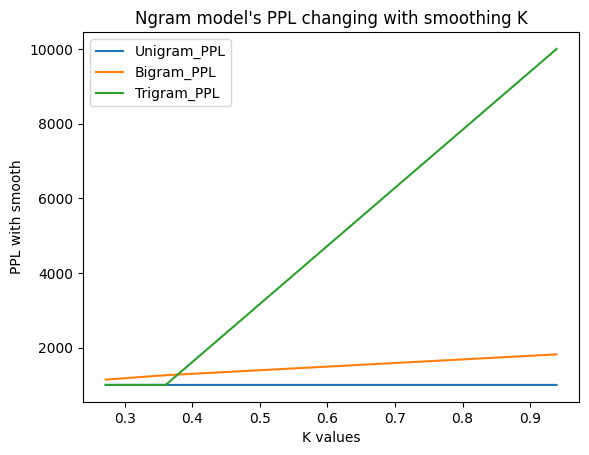

In [ ]:
k_list = [K1, K2, K3]
uni_ppl_smooth_list = [uni_ppl_smooth_K1, uni_ppl_smooth_K2, uni_ppl_smooth_K3]
bi_ppl_smooth_list = [bi_ppl_smooth_K1, bi_ppl_smooth_K2, bi_ppl_smooth_K3]
tri_ppl_smooth_list = [tri_ppl_smooth_K1, uni_ppl_smooth_K2, uni_ppl_smooth_K3]

plt.plot(k_list, uni_ppl_smooth_list, label='Unigram_PPL')
plt.plot(k_list, bi_ppl_smooth_list, label='Bigram_PPL')
plt.plot(k_list, tri_ppl_smooth_list, label='Trigram_PPL')

plt.xlabel('K values')
plt.ylabel('PPL with smooth')
plt.title('Ngram model\'s PPL changing with smoothing K')
plt.legend()


plt.show()

# 1.2 (e)
In my training set, the unsmoothed versions for the unigram, bigram, and trigram models exhibit an expected pattern, where the trigram model (with the smallest perplexity (PPL) value) ideally performs better than the bigram model, which in turn performs better than the unigram model (with the largest PPL value). However, the situation is reversed in my smoothed versions, where the PPL of the unigram model is less than that of the bigram model, which is less than that of the trigram model. This discrepancy could serve as evidence of overestimation resulting from Laplace smoothing. In the trigram model, there are numerous rare trigram tokens with extremely low frequencies present in the corpus. Consequently, their probabilities could be significantly lower compared to the probabilities of unigram tokens in the unigram model. Thus, Laplace smoothing tends to overestimate the probabilities of these rare trigram tokens. This same phenomenon is observed in the smoothed versions for the development and test sets as well.

For the development and test sets, the unsmoothed versions of the bigram and trigram models yield infinite values. This occurs because my bigram and trigram models lack probabilities for certain bigram and trigram tokens in the development and test sets, resulting in zero probabilities. Consequently, when calculating perplexity, attempting to take the logarithm of zero probability results in an infinite value.

# 1.3 (a)

In [ ]:
opti_hyper = [0.531742, 0.420426, 0.047832]
print(f"My best combination of hyperparameters is: {opti_hyper[0]}, {opti_hyper[1]}, {opti_hyper[2]}")
interp_ppl_unsmooth = perplexity_interpolated(K, dev_f, vocab, size, opti_hyper, unigram_model, bigram_model, trigram_model, unigram_freq, bigram_freq, spec_freq, False)
interp_ppl_smooth = perplexity_interpolated(K, dev_f, vocab, size, opti_hyper, unigram_model, bigram_model, trigram_model, unigram_freq, bigram_freq, spec_freq, True)
print(f"perplexity of interpolation on dev without smoothing for hyperparameters {opti_hyper[0]}, {opti_hyper[1]}, {opti_hyper[2]}:  ", interp_ppl_unsmooth)
print(f"perplexity of interpolation on dev with smoothing for hyperparameters {opti_hyper[0]}, {opti_hyper[1]}, {opti_hyper[2]}:  ", interp_ppl_smooth)

My best combination of hyperparameters is: 0.531742, 0.420426, 0.047832
perplexity of interpolation on dev without smoothing for hyperparameters 0.531742, 0.420426, 0.047832:   340.0894018669363
perplexity of interpolation on dev with smoothing for hyperparameters 0.531742, 0.420426, 0.047832:   360.0779423181838


In [ ]:
pool = [0.1, 0.3, 0.6]
pool1 = gen_interp_fixed(0.1)
pool2 = gen_interp_fixed(0.2)
pool3 = gen_interp_rand()
pool4 = gen_interp_rand()
pool5 = gen_interp_rand()

In [ ]:
interp_ppl_unsmooth = perplexity_interpolated(K, dev_f, vocab, size, pool, unigram_model, bigram_model, trigram_model, unigram_freq, bigram_freq, spec_freq, False)
interp_ppl_smooth = perplexity_interpolated(K, dev_f, vocab, size, pool, unigram_model, bigram_model, trigram_model, unigram_freq, bigram_freq, spec_freq, True)
print(f"perplexity of interpolation on dev without smoothing for hyperparameters {pool[0]}, {pool[1]}, {pool[2]}:  ", interp_ppl_unsmooth)
print(f"perplexity of interpolation on dev with smoothing for hyperparameters {pool[0]}, {pool[1]}, {pool[2]}:  ", interp_ppl_smooth)
interp_ppl_unsmooth = perplexity_interpolated(K, train_f, vocab, size, pool, unigram_model, bigram_model, trigram_model, unigram_freq, bigram_freq, spec_freq, False)
interp_ppl_smooth = perplexity_interpolated(K, train_f, vocab, size, pool, unigram_model, bigram_model, trigram_model, unigram_freq, bigram_freq, spec_freq, True)
print(f"perplexity of interpolation on train without smoothing for hyperparameters {pool[0]}, {pool[1]}, {pool[2]}:  ", interp_ppl_unsmooth)
print(f"perplexity of interpolation on train with smoothing for hyperparameters {pool[0]}, {pool[1]}, {pool[2]}:  ", interp_ppl_smooth)

interp_ppl_unsmooth = perplexity_interpolated(K, dev_f, vocab, size, pool1, unigram_model, bigram_model, trigram_model, unigram_freq, bigram_freq, spec_freq, False)
interp_ppl_smooth = perplexity_interpolated(K, dev_f, vocab, size, pool1, unigram_model, bigram_model, trigram_model, unigram_freq, bigram_freq, spec_freq, True)
print(f"perplexity of interpolation on dev without smoothing for hyperparameters {pool1[0]}, {pool1[1]}, {pool1[2]}:  ", interp_ppl_unsmooth)
print(f"perplexity of interpolation on dev with smoothing for hyperparameters {pool1[0]}, {pool1[1]}, {pool1[2]}:  ", interp_ppl_smooth)
interp_ppl_unsmooth = perplexity_interpolated(K, train_f, vocab, size, pool1, unigram_model, bigram_model, trigram_model, unigram_freq, bigram_freq, spec_freq, False)
interp_ppl_smooth = perplexity_interpolated(K, train_f, vocab, size, pool1, unigram_model, bigram_model, trigram_model, unigram_freq, bigram_freq, spec_freq, True)
print(f"perplexity of interpolation on train without smoothing for hyperparameters {pool1[0]}, {pool1[1]}, {pool1[2]}:  ", interp_ppl_unsmooth)
print(f"perplexity of interpolation on train with smoothing for hyperparameters {pool1[0]}, {pool1[1]}, {pool1[2]}:  ", interp_ppl_smooth)

interp_ppl_unsmooth = perplexity_interpolated(K, dev_f, vocab, size, pool2, unigram_model, bigram_model, trigram_model, unigram_freq, bigram_freq, spec_freq, False)
interp_ppl_smooth = perplexity_interpolated(K, dev_f, vocab, size, pool2, unigram_model, bigram_model, trigram_model, unigram_freq, bigram_freq, spec_freq, True)
print(f"perplexity of interpolation on dev without smoothing for hyperparameters {pool2[0]}, {pool2[1]}, {pool2[2]}:  ", interp_ppl_unsmooth)
print(f"perplexity of interpolation on dev with smoothing for hyperparameters {pool2[0]}, {pool2[1]}, {pool2[2]}:  ", interp_ppl_smooth)
interp_ppl_unsmooth = perplexity_interpolated(K, train_f, vocab, size, pool2, unigram_model, bigram_model, trigram_model, unigram_freq, bigram_freq, spec_freq, False)
interp_ppl_smooth = perplexity_interpolated(K, train_f, vocab, size, pool2, unigram_model, bigram_model, trigram_model, unigram_freq, bigram_freq, spec_freq, True)
print(f"perplexity of interpolation on train without smoothing for hyperparameters {pool2[0]}, {pool2[1]}, {pool2[2]}:  ", interp_ppl_unsmooth)
print(f"perplexity of interpolation on train with smoothing for hyperparameters {pool2[0]}, {pool2[1]}, {pool2[2]}:  ", interp_ppl_smooth)

interp_ppl_unsmooth = perplexity_interpolated(K, dev_f, vocab, size, pool3, unigram_model, bigram_model, trigram_model, unigram_freq, bigram_freq, spec_freq, False)
interp_ppl_smooth = perplexity_interpolated(K, dev_f, vocab, size, pool3, unigram_model, bigram_model, trigram_model, unigram_freq, bigram_freq, spec_freq, True)
print(f"perplexity of interpolation on dev without smoothing for hyperparameters {pool3[0]}, {pool3[1]}, {pool3[2]}:  ", interp_ppl_unsmooth)
print(f"perplexity of interpolation on dev with smoothing for hyperparameters {pool3[0]}, {pool3[1]}, {pool3[2]}:  ", interp_ppl_smooth)
interp_ppl_unsmooth = perplexity_interpolated(K, train_f, vocab, size, pool3, unigram_model, bigram_model, trigram_model, unigram_freq, bigram_freq, spec_freq, False)
interp_ppl_smooth = perplexity_interpolated(K, train_f, vocab, size, pool3, unigram_model, bigram_model, trigram_model, unigram_freq, bigram_freq, spec_freq, True)
print(f"perplexity of interpolation on train without smoothing for hyperparameters {pool3[0]}, {pool3[1]}, {pool3[2]}:  ", interp_ppl_unsmooth)
print(f"perplexity of interpolation on train with smoothing for hyperparameters {pool3[0]}, {pool3[1]}, {pool3[2]}:  ", interp_ppl_smooth)

interp_ppl_unsmooth = perplexity_interpolated(K, dev_f, vocab, size, pool4, unigram_model, bigram_model, trigram_model, unigram_freq, bigram_freq, spec_freq, False)
interp_ppl_smooth = perplexity_interpolated(K, dev_f, vocab, size, pool4, unigram_model, bigram_model, trigram_model, unigram_freq, bigram_freq, spec_freq, True)
print(f"perplexity of interpolation on dev without smoothing for hyperparameters {pool4[0]}, {pool4[1]}, {pool4[2]}:  ", interp_ppl_unsmooth)
print(f"perplexity of interpolation on dev with smoothing for hyperparameters {pool4[0]}, {pool4[1]}, {pool4[2]}:  ", interp_ppl_smooth)
interp_ppl_unsmooth = perplexity_interpolated(K, train_f, vocab, size, pool4, unigram_model, bigram_model, trigram_model, unigram_freq, bigram_freq, spec_freq, False)
interp_ppl_smooth = perplexity_interpolated(K, train_f, vocab, size, pool4, unigram_model, bigram_model, trigram_model, unigram_freq, bigram_freq, spec_freq, True)
print(f"perplexity of interpolation on train without smoothing for hyperparameters {pool4[0]}, {pool4[1]}, {pool4[2]}:  ", interp_ppl_unsmooth)
print(f"perplexity of interpolation on train with smoothing for hyperparameters {pool4[0]}, {pool4[1]}, {pool4[2]}:  ", interp_ppl_smooth)

interp_ppl_unsmooth = perplexity_interpolated(K, dev_f, vocab, size, pool5, unigram_model, bigram_model, trigram_model, unigram_freq, bigram_freq, spec_freq, False)
interp_ppl_smooth = perplexity_interpolated(K, dev_f, vocab, size, pool5, unigram_model, bigram_model, trigram_model, unigram_freq, bigram_freq, spec_freq, True)
print(f"perplexity of interpolation on dev without smoothing for hyperparameters {pool5[0]}, {pool5[1]}, {pool5[2]}:  ", interp_ppl_unsmooth)
print(f"perplexity of interpolation on dev with smoothing for hyperparameters {pool5[0]}, {pool5[1]}, {pool5[2]}:  ", interp_ppl_smooth)
interp_ppl_unsmooth = perplexity_interpolated(K, train_f, vocab, size, pool5, unigram_model, bigram_model, trigram_model, unigram_freq, bigram_freq, spec_freq, False)
interp_ppl_smooth = perplexity_interpolated(K, train_f, vocab, size, pool5, unigram_model, bigram_model, trigram_model, unigram_freq, bigram_freq, spec_freq, True)
print(f"perplexity of interpolation on train without smoothing for hyperparameters {pool5[0]}, {pool5[1]}, {pool5[2]}:  ", interp_ppl_unsmooth)
print(f"perplexity of interpolation on train with smoothing for hyperparameters {pool5[0]}, {pool5[1]}, {pool5[2]}:  ", interp_ppl_smooth)

perplexity of interpolation on dev without smoothing for hyperparameters 0.1, 0.3, 0.6:   534.6931564837076
perplexity of interpolation on dev with smoothing for hyperparameters 0.1, 0.3, 0.6:   585.5165835126105
perplexity of interpolation on train without smoothing for hyperparameters 0.1, 0.3, 0.6:   11.883591542089817
perplexity of interpolation on train with smoothing for hyperparameters 0.1, 0.3, 0.6:   192.95334611988721
perplexity of interpolation on dev without smoothing for hyperparameters 0.14755282570936595, 0.21850442546834697, 0.6339427488222871:   517.2581011914799
perplexity of interpolation on dev with smoothing for hyperparameters 0.14755282570936595, 0.21850442546834697, 0.6339427488222871:   625.4485806927094
perplexity of interpolation on train without smoothing for hyperparameters 0.14755282570936595, 0.21850442546834697, 0.6339427488222871:   11.709528505659422
perplexity of interpolation on train with smoothing for hyperparameters 0.14755282570936595, 0.21850442

In [ ]:
interp_ppl_unsmooth = perplexity_interpolated(K, test_f, vocab, size, pool, unigram_model, bigram_model, trigram_model, unigram_freq, bigram_freq, spec_freq, False)
interp_ppl_smooth = perplexity_interpolated(K, test_f, vocab, size, pool, unigram_model, bigram_model, trigram_model, unigram_freq, bigram_freq, spec_freq, True)
print(f"perplexity of interpolation on test without smoothing for hyperparameters {pool[0]}, {pool[1]}, {pool[2]}:  ", interp_ppl_unsmooth)
print(f"perplexity of interpolation on test with smoothing for hyperparameters {pool[0]}, {pool[1]}, {pool[2]}:  ", interp_ppl_smooth)

interp_ppl_unsmooth = perplexity_interpolated(K, test_f, vocab, size, pool1, unigram_model, bigram_model, trigram_model, unigram_freq, bigram_freq, spec_freq, False)
interp_ppl_smooth = perplexity_interpolated(K, test_f, vocab, size, pool1, unigram_model, bigram_model, trigram_model, unigram_freq, bigram_freq, spec_freq, True)
print(f"perplexity of interpolation on test without smoothing for hyperparameters {pool1[0]}, {pool1[1]}, {pool1[2]}:  ", interp_ppl_unsmooth)
print(f"perplexity of interpolation on test with smoothing for hyperparameters {pool1[0]}, {pool1[1]}, {pool1[2]}:  ", interp_ppl_smooth)

interp_ppl_unsmooth = perplexity_interpolated(K, test_f, vocab, size, pool2, unigram_model, bigram_model, trigram_model, unigram_freq, bigram_freq, spec_freq, False)
interp_ppl_smooth = perplexity_interpolated(K, test_f, vocab, size, pool2, unigram_model, bigram_model, trigram_model, unigram_freq, bigram_freq, spec_freq, True)
print(f"perplexity of interpolation on test without smoothing for hyperparameters {pool2[0]}, {pool2[1]}, {pool2[2]}:  ", interp_ppl_unsmooth)
print(f"perplexity of interpolation on test with smoothing for hyperparameters {pool2[0]}, {pool2[1]}, {pool2[2]}:  ", interp_ppl_smooth)

interp_ppl_unsmooth = perplexity_interpolated(K, test_f, vocab, size, pool3, unigram_model, bigram_model, trigram_model, unigram_freq, bigram_freq, spec_freq, False)
interp_ppl_smooth = perplexity_interpolated(K, test_f, vocab, size, pool3, unigram_model, bigram_model, trigram_model, unigram_freq, bigram_freq, spec_freq, True)
print(f"perplexity of interpolation on test without smoothing for hyperparameters {pool3[0]}, {pool3[1]}, {pool3[2]}:  ", interp_ppl_unsmooth)
print(f"perplexity of interpolation on test with smoothing for hyperparameters {pool3[0]}, {pool3[1]}, {pool3[2]}:  ", interp_ppl_smooth)

interp_ppl_unsmooth = perplexity_interpolated(K, test_f, vocab, size, pool4, unigram_model, bigram_model, trigram_model, unigram_freq, bigram_freq, spec_freq, False)
interp_ppl_smooth = perplexity_interpolated(K, test_f, vocab, size, pool4, unigram_model, bigram_model, trigram_model, unigram_freq, bigram_freq, spec_freq, True)
print(f"perplexity of interpolation on test without smoothing for hyperparameters {pool4[0]}, {pool4[1]}, {pool4[2]}:  ", interp_ppl_unsmooth)
print(f"perplexity of interpolation on test with smoothing for hyperparameters {pool4[0]}, {pool4[1]}, {pool4[2]}:  ", interp_ppl_smooth)

interp_ppl_unsmooth = perplexity_interpolated(K, test_f, vocab, size, pool5, unigram_model, bigram_model, trigram_model, unigram_freq, bigram_freq, spec_freq, False)
interp_ppl_smooth = perplexity_interpolated(K, test_f, vocab, size, pool5, unigram_model, bigram_model, trigram_model, unigram_freq, bigram_freq, spec_freq, True)
print(f"perplexity of interpolation on test without smoothing for hyperparameters {pool5[0]}, {pool5[1]}, {pool5[2]}:  ", interp_ppl_unsmooth)
print(f"perplexity of interpolation on test with smoothing for hyperparameters {pool5[0]}, {pool5[1]}, {pool5[2]}:  ", interp_ppl_smooth)

perplexity of interpolation on dev without smoothing for hyperparameters 0.1, 0.3, 0.6:   543.0683055194663
perplexity of interpolation on dev with smoothing for hyperparameters 0.1, 0.3, 0.6:   594.6286705518622
perplexity of interpolation on dev without smoothing for hyperparameters 0.14755282570936595, 0.21850442546834697, 0.6339427488222871:   523.8469791306345
perplexity of interpolation on dev with smoothing for hyperparameters 0.14755282570936595, 0.21850442546834697, 0.6339427488222871:   633.3699879295476
perplexity of interpolation on dev without smoothing for hyperparameters 0.17436318600033432, 0.21272670103405855, 0.6129101129656072:   499.27706305726906
perplexity of interpolation on dev with smoothing for hyperparameters 0.17436318600033432, 0.21272670103405855, 0.6129101129656072:   616.1486606091681
perplexity of interpolation on dev without smoothing for hyperparameters 0.47512142959162307, 0.18925370967601468, 0.33562486073236225:   386.8955500845346
perplexity of in

# 1.3 (c)
Using only half of the training data could lead to a decrease in the perplexity of previously unseen data, primarily by lowering the risk of overfitting. When my model is trained on a large dataset and closely fits to it, it may struggle when faced with an unseen dataset that differs significantly from the training set. By using a smaller subset of the data, the model is less likely to overfit to specific patterns present in the training set, resulting in better generalization to new, unseen data.

Perplexity:
perplexity of unigram trained by whole file on test with smoothing:  998.247018669925

perplexity of bigram trained by whole file on test with smoothing:   1864.0726257705326

perplexity of trigram trained by whole file on test with smoothing:  10160.802419885664

perplexity of unigram trained by half file on test with smoothing:  812.9105609540952

perplexity of bigram trained by half file on test with smoothing:   1552.1012805741357

perplexity of trigram trained by half file on test with smoothing:  7361.21230049765

In [ ]:
half_train_f = train_f[:(len(train_f) // 2)]
spec_freq_half = len(half_train_f)
unigram_freq_half = count_for_unitoken(half_train_f)
unk_list_half = filter_unk(unigram_freq_half, unk)
vocab_half = unigram_freq_half.keys()
size_half = len(vocab)
bigram_freq_half = count_for_bitoken(half_train_f, unk_list)
unigram_model_half = unigram(half_train_f, K, unk)
bigram_model_half = bigram(half_train_f, K, unk)
trigram_model_half = trigram(half_train_f, bigram_model_half, K, unk)

In [ ]:
print("perplexity of unigram on test without smoothing: ", perplexity(K, 1, unigram_model_half, test_f, vocab_half, unigram_freq_half, bigram_freq_half, spec_freq_half))
print("perplexity of bigram on test without smoothing:  ", perplexity(K, 2, bigram_model_half, test_f, vocab_half, unigram_freq_half, bigram_freq_half, spec_freq_half))
print("perplexity of trigram on test without smoothing: ", perplexity(K, 3, trigram_model_half, test_f, vocab_half, unigram_freq_half, bigram_freq_half, spec_freq_half))
print("perplexity of unigram on test with smoothing: ", perplexity_laplace(K, 1, unigram_model_half, test_f, vocab_half, unigram_freq_half, bigram_freq_half, spec_freq_half))
print("perplexity of bigram on test with smoothing:  ", perplexity_laplace(K, 2, bigram_model_half, test_f, vocab_half, unigram_freq_half, bigram_freq_half, spec_freq_half))
print("perplexity of trigram on test with smoothing: ", perplexity_laplace(K, 3, trigram_model_half, test_f, vocab_half, unigram_freq_half, bigram_freq_half, spec_freq_half))

perplexity of unigram on test without smoothing:  812.6340218368663
perplexity of bigram on test without smoothing:   inf
perplexity of trigram on test without smoothing:  inf
perplexity of unigram on test with smoothing:  812.9105609540952
perplexity of bigram on test with smoothing:   1552.1012805741357
perplexity of trigram on test with smoothing:  7361.21230049765


# 1.3 (d)
Converting all tokens that occurred fewer than five times to \<unk> could lower the perplexity on previously unseen data compared to solely replacing tokens that appeared only once. This strategy likely enhances the model's generalization capabilities. By substituting tokens with less than five occurrences to \<unk>, the model gains exposure to a wider range of vocabulary during training, enabling it to better handle unseen data with a broader vocabulary spectrum.
perplexity of unigram on test without smoothing when unk = 1:  1114.6534964214973

perplexity of bigram on test without smoothing when unk = 1:   inf

perplexity of trigram on test without smoothing when unk = 1:  inf

perplexity of unigram on test with smoothing when unk = 1:  1115.6971793450489

perplexity of bigram on test with smoothing when unk = 1:   2654.5032901347495

perplexity of trigram on test with smoothing when unk = 1:  14862.456000393395

perplexity of unigram on test without smoothing when unk = 5:  848.473970880849

perplexity of bigram on test without smoothing when unk = 5:   inf

perplexity of trigram on test without smoothing when unk = 5:  inf

perplexity of unigram on test with smoothing when unk = 5:  847.7793318116068

perplexity of bigram on test with smoothing when unk = 5:   1221.3500472157966

perplexity of trigram on test with smoothing when unk = 5:  6402.409842898671







In [ ]:
# convert the word with frequency less than two (apper only once) to unk
unk2 = 2
unigram_freq_unk2 = count_for_unitoken(train_f)
unk_list_unk2 = filter_unk(unigram_freq_unk2, unk2)
vocab_unk2 = unigram_freq_unk2.keys()
size_unk2 = len(vocab_unk2)
bigram_freq_unk2 = count_for_bitoken(train_f, unk_list)
unigram_model_unk2 = unigram(train_f, K, unk2)
bigram_model_unk2 = bigram(train_f, K, unk2)
trigram_model_unk2 = trigram(train_f, bigram_model_unk2, K, unk2)
print("perplexity of unigram on test without smoothing when unk = 1: ", perplexity(K, 1, unigram_model_unk2, test_f, vocab_unk2, unigram_freq_unk2, bigram_freq_unk2, spec_freq))
print("perplexity of bigram on test without smoothing when unk = 1:  ", perplexity(K, 2, bigram_model_unk2, test_f, vocab_unk2, unigram_freq_unk2, bigram_freq_unk2, spec_freq))
print("perplexity of trigram on test without smoothing when unk = 1: ", perplexity(K, 3, trigram_model_unk2, test_f, vocab_unk2, unigram_freq_unk2, bigram_freq_unk2, spec_freq))
print("perplexity of unigram on test with smoothing when unk = 1: ", perplexity_laplace(K, 1, unigram_model_unk2, test_f, vocab_unk2, unigram_freq_unk2, bigram_freq_unk2, spec_freq))
print("perplexity of bigram on test with smoothing when unk = 1:  ", perplexity_laplace(K, 2, bigram_model_unk2, test_f, vocab_unk2, unigram_freq_unk2, bigram_freq_unk2, spec_freq))
print("perplexity of trigram on test with smoothing when unk = 1: ", perplexity_laplace(K, 3, trigram_model_unk2, test_f, vocab_unk2, unigram_freq_unk2, bigram_freq_unk2, spec_freq))

# convert the word with frequency less than five to unk
unk5 = 5
unigram_freq_unk5 = count_for_unitoken(train_f)
unk_list_unk5 = filter_unk(unigram_freq_unk5, unk5)
vocab_unk5 = unigram_freq_unk5.keys()
size_unk5 = len(vocab_unk5)
bigram_freq_unk5 = count_for_bitoken(train_f, unk_list)
unigram_model_unk5 = unigram(train_f, K, unk5)
bigram_model_unk5 = bigram(train_f, K, unk5)
trigram_model_unk5 = trigram(train_f, bigram_model_unk5, K, unk5)
print("perplexity of unigram on test without smoothing when unk = 5: ", perplexity(K, 1, unigram_model_unk5, test_f, vocab_unk5, unigram_freq_unk5, bigram_freq_unk5, spec_freq))
print("perplexity of bigram on test without smoothing when unk = 5:  ", perplexity(K, 2, bigram_model_unk5, test_f, vocab_unk5, unigram_freq_unk5, bigram_freq_unk5, spec_freq))
print("perplexity of trigram on test without smoothing when unk = 5: ", perplexity(K, 3, trigram_model_unk5, test_f, vocab_unk5, unigram_freq_unk5, bigram_freq_unk5, spec_freq))
print("perplexity of unigram on test with smoothing when unk = 5: ", perplexity_laplace(K, 1, unigram_model_unk5, test_f, vocab_unk5, unigram_freq_unk5, bigram_freq_unk5, spec_freq))
print("perplexity of bigram on test with smoothing when unk = 5:  ", perplexity_laplace(K, 2, bigram_model_unk5, test_f, vocab_unk5, unigram_freq_unk5, bigram_freq_unk5, spec_freq))
print("perplexity of trigram on test with smoothing when unk = 5: ", perplexity_laplace(K, 3, trigram_model_unk5, test_f, vocab_unk5, unigram_freq_unk5, bigram_freq_unk5, spec_freq))


perplexity of unigram on test without smoothing when unk = 1:  1114.6534964214973
perplexity of bigram on test without smoothing when unk = 1:   inf
perplexity of trigram on test without smoothing when unk = 1:  inf
perplexity of unigram on test with smoothing when unk = 1:  1115.6971793450489
perplexity of bigram on test with smoothing when unk = 1:   2654.5032901347495
perplexity of trigram on test with smoothing when unk = 1:  14862.456000393395
perplexity of unigram on test without smoothing when unk = 5:  848.473970880849
perplexity of bigram on test without smoothing when unk = 5:   inf
perplexity of trigram on test without smoothing when unk = 5:  inf
perplexity of unigram on test with smoothing when unk = 5:  847.7793318116068
perplexity of bigram on test with smoothing when unk = 5:   1221.3500472157966
perplexity of trigram on test with smoothing when unk = 5:  6402.409842898671
